In [1]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

# プロット

In [3]:
def plot_charts(list_symbol: list):
    FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
    fm.fontManager.addfont(FONT_PATH)
    
    # FontPropertiesオブジェクト生成（名前の取得のため）
    font_prop = fm.FontProperties(fname=FONT_PATH)
    font_prop.get_name()
    
    plt.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['font.size'] = 10

    n = len(list_symbol)
    fig = plt.figure(figsize=(10, 20))
    gs = fig.add_gridspec(
        n, 1,
        wspace=0.0, hspace=0.0
    )
    ax = dict()
    for i, axis in enumerate(gs.subplots(sharex='col')):
        ax[i] = axis
    
    for i, symbol in enumerate(list_symbol):
        ticker = yf.Ticker(symbol)
        df = ticker.history(period='6mo', interval='1d')
        dict_psar = psar(df)
        apds  = [
            mpf.make_addplot(
                dict_psar['bear'],
                type='scatter',
                marker='o',
                markersize=10,
                color='blue',
                label='downtrend',
                ax=ax[i]
            ),
            mpf.make_addplot(
                dict_psar['bull'],
                type='scatter',
                marker='o',
                markersize=10,
                color='red',
                label='uptrend',
                ax=ax[i]
            ),
        ] 
        mpf.plot(
            df,
            type='candle',
            style='default',
            volume=False,
            addplot=apds,
            xrotation=0,
            ylabel='%s\n(%s)' % (ticker.info['shortName'], symbol),
            ax=ax[i],
        )
        ax[i].grid()

    plt.tight_layout()

# 米国市場

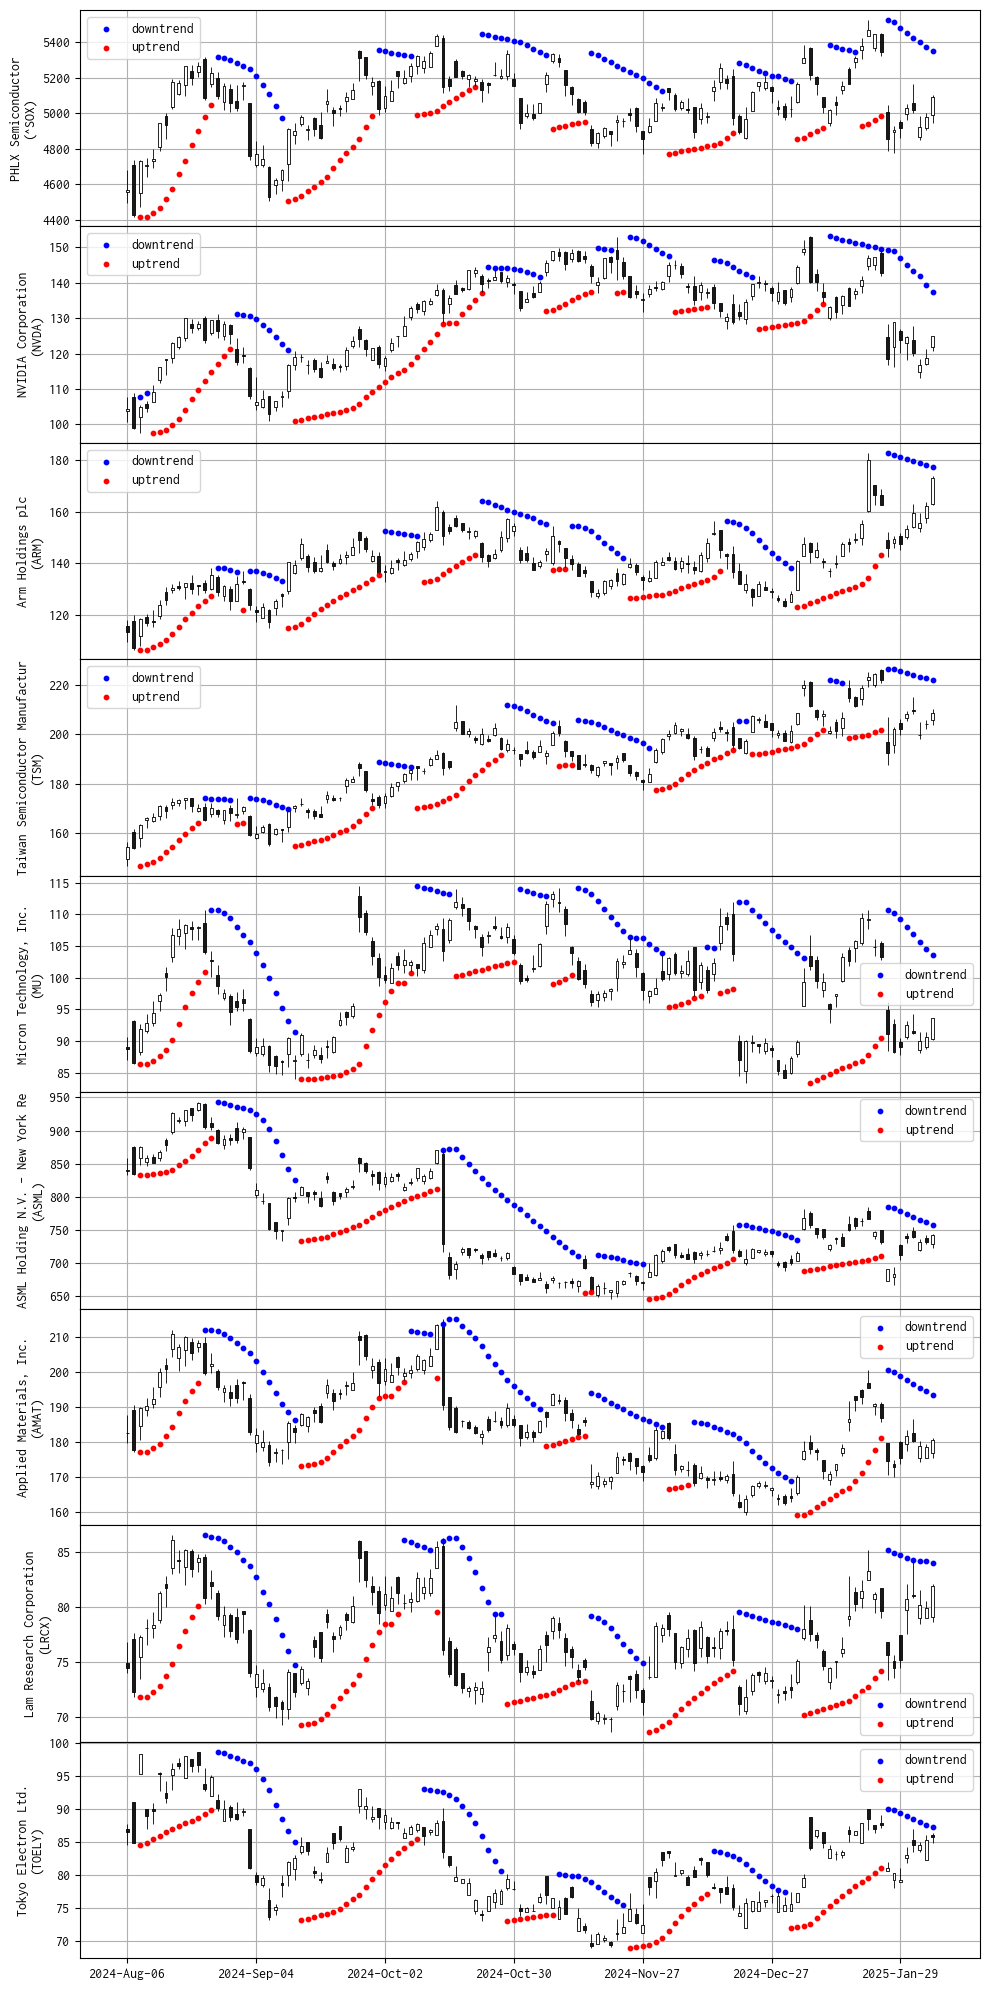

In [4]:
list_symbol = ['^SOX', 'NVDA', 'ARM', 'TSM', 'MU', 'ASML', 'AMAT', 'LRCX', 'TOELY']
plot_charts(list_symbol)
plt.savefig('report_semicon_us.png')

# 日本市場

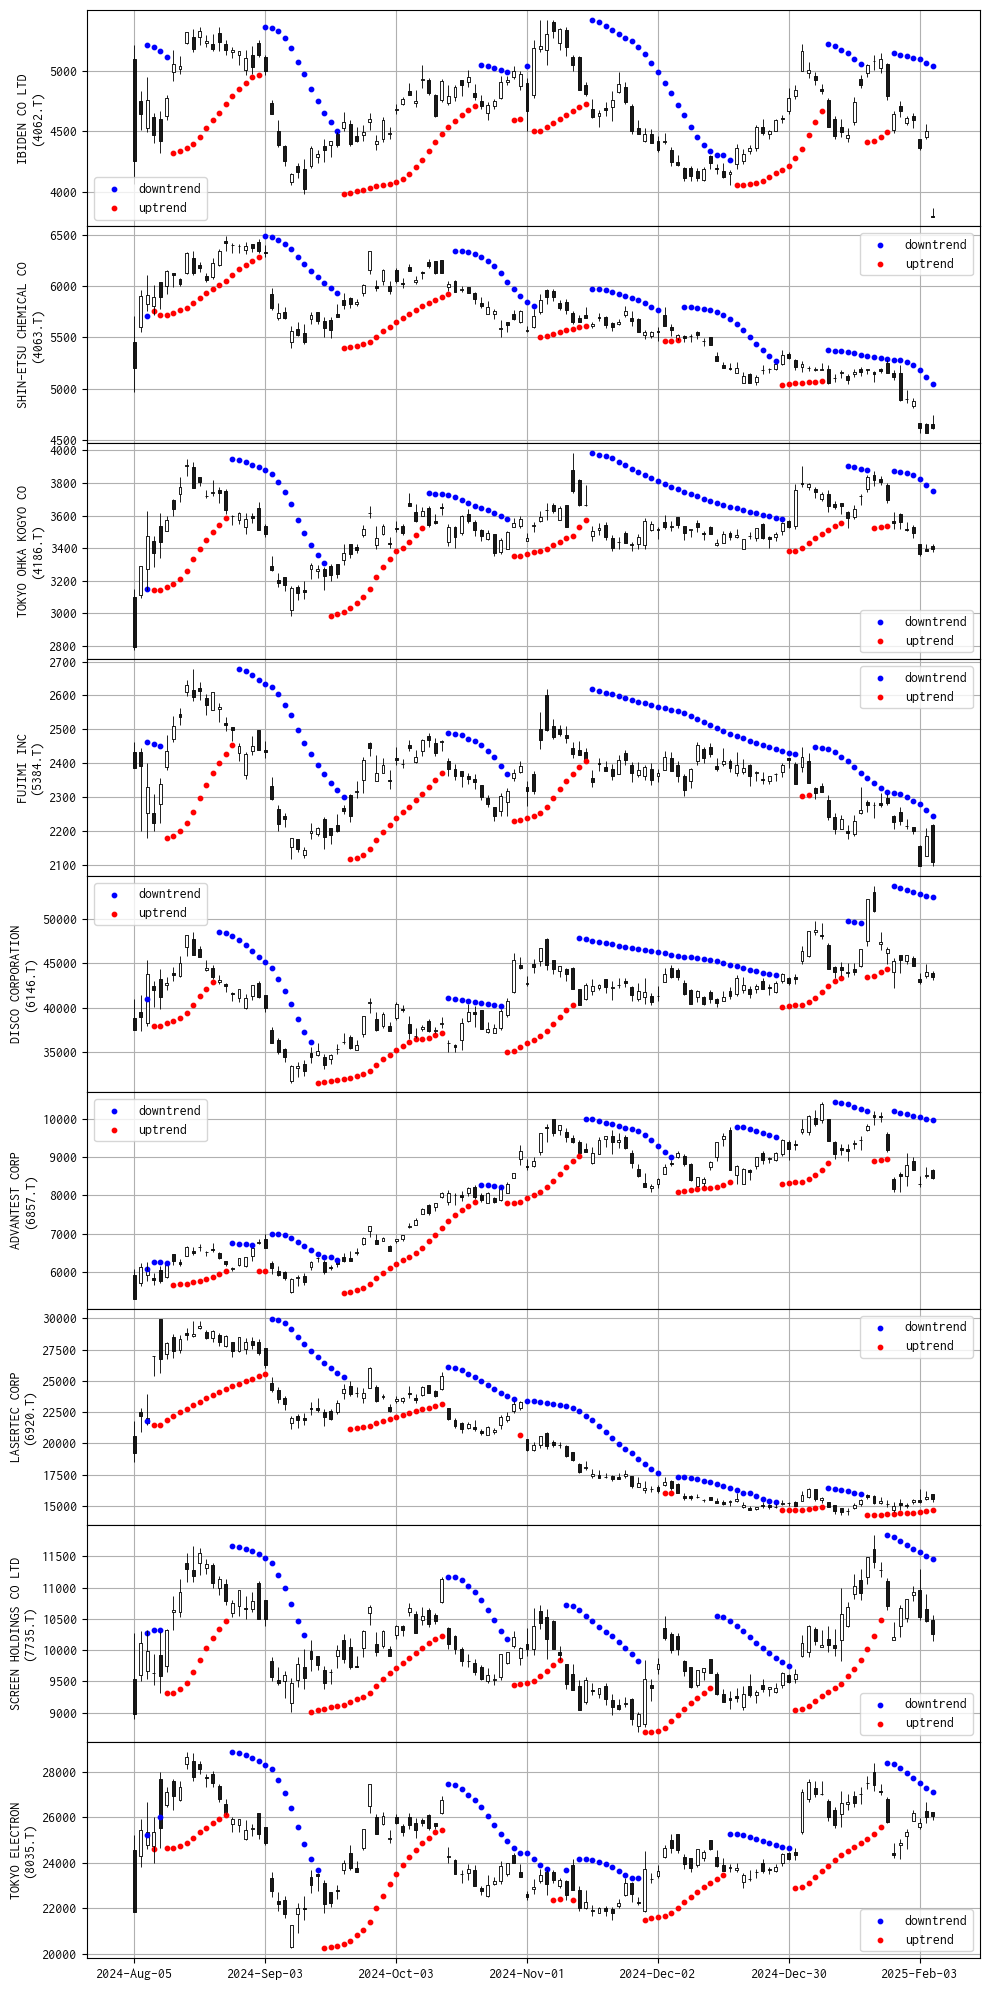

In [5]:
list_symbol = ['4062.T', '4063.T', '4186.T', '5384.T', '6146.T', '6857.T', '6920.T', '7735.T', '8035.T']
plot_charts(list_symbol)
plt.savefig('report_semicon_jp.png')